# 01_import dataset

## 01-1_import data

In [1]:
import os
import json
import pandas as pd

#https://drive.google.com/drive/folders/18qV82fNY3IIWu3BRoGqm_LNgJzE8Akbr?usp=drive_link
#base_dir = "/Users/Andypon/10_交大研究所/1141_01_機器學習與金融科技/data"
base_dir= '/Users/andyw.p.chen/Documents/Project/datasets'
#base_dir=  "c:\Users\user\Downloads\datasets"

def load_json_to_df(filename: str) -> pd.DataFrame:
    file_path = os.path.join(base_dir, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 如果是 { "target": {id: value, ...} }
    if isinstance(data, dict) and len(data) == 1 and isinstance(next(iter(data.values())), dict):
        key, inner = next(iter(data.items()))
        return pd.DataFrame(list(inner.items()), columns=["id", key])

    # dict of scalar
    if isinstance(data, dict):
        return pd.DataFrame([{"code": k, "desc": v} for k, v in data.items()])

    # list of dict
    elif isinstance(data, list):
        return pd.DataFrame(data)

    else:
        raise ValueError(f"Unsupported JSON structure in {filename}: {type(data)}")


def load_csv_to_df(filename: str) -> pd.DataFrame:
    """讀取 CSV 並轉為 DataFrame。"""
    return pd.read_csv(os.path.join(base_dir, filename))

# JSON 資料
##mcc_codes_df = load_json_to_df("mcc_codes.json")
train_fraud_labels_df = load_json_to_df("train_fraud_labels.json")

# CSV 資料
cards_df = load_csv_to_df("cards_data.csv")
transactions_df = load_csv_to_df("transactions_data.csv")
users_df = load_csv_to_df("users_data.csv")

# 簡單檢查
#print(mcc_codes_df.head())
#print(train_fraud_labels_df.head())
#print(cards_df.head())
#print(transactions_df.head())
#print(users_df.apthead())


## 01-2_rename variable in each data set

In [2]:
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'id': 'transactions_id'})
train_fraud_labels_df = train_fraud_labels_df.rename(columns={'target': 'is_fraud'})

cards_df = cards_df.rename(columns={'id':'card_id'})

users_df = users_df.rename(columns={'id':'client_id'})

transactions_df = transactions_df.rename(columns={'mcc': 'mcc_code'})
transactions_df = transactions_df.rename(columns={'id': 'transaction_id'})




## 01-3_變數型態統一及缺失值處理

In [3]:
def add_missing_flags(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    在 DataFrame 中對指定欄位建立 missing flag 欄位
    flag=1 表示缺失值，flag=0 表示非缺失值
    
    參數
    ----
    df : pd.DataFrame
        輸入的資料框
    cols : list
        要檢查的欄位名稱清單
    
    回傳
    ----
    pd.DataFrame : 新的資料框 (含新增的 flag 欄位)
    """
    for col in cols:
        df[f"{col}_missing_flag"] = df[col].isna().astype(int)
    return df

transactions_df = add_missing_flags(transactions_df, ["merchant_state", "zip", "errors"])

In [4]:
##train_fraud_labels_df##
train_fraud_labels_df["is_fraud"]=train_fraud_labels_df["is_fraud"].astype("category") 
train_fraud_labels_df["transactions_id"]=train_fraud_labels_df["transactions_id"].astype(int) #合併資料需要

##cards_df##
cards_df["card_brand"]=cards_df["card_brand"].astype("category") 
cards_df["card_type"]=cards_df["card_type"].astype("category")
#####不要load這行 cards_df["expires"]=pd.to_datetime(cards_df["expires"], format="%m/%Y")
cards_df["expires"] = pd.to_datetime(cards_df["expires"], format="%m/%Y").dt.to_period("M")
cards_df["has_chip"]=cards_df["has_chip"].astype("category")

cards_df['credit_limit'] = cards_df['credit_limit'].replace(r'[\$,]', '', regex=True).astype(int)
#####不要load這行 cards_df["acct_open_date"]=pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y")
cards_df["acct_open_date"] = pd.to_datetime(cards_df["acct_open_date"], format="%m/%Y").dt.to_period("M")
#####不要load這行 cards_df["year_pin_last_changed"]=pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y")
cards_df["year_pin_last_changed"] = pd.to_datetime(cards_df["year_pin_last_changed"], format="%Y").dt.to_period("Y")
cards_df["card_on_dark_web"]=cards_df["card_on_dark_web"].astype("category") 

##users_df##
users_df["birth_year"] = pd.to_datetime(users_df["birth_year"], format="%Y").dt.to_period("Y")
users_df["birth_month"] = pd.to_datetime(users_df["birth_month"], format="%m").dt.to_period("M")
users_df["gender"]=users_df["gender"].astype("category") 
users_df['per_capita_income'] = users_df['per_capita_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['yearly_income'] = users_df['yearly_income'].replace(r'[\$,]', '', regex=True).astype(int)
users_df['total_debt'] = users_df['total_debt'].replace(r'[\$,]', '', regex=True).astype(int)

##transactions_df##
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
#浮點數轉整數原因確定？
transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float).astype(int)
##負數取log調成1
#transactions_df['amount'] = transactions_df['amount'].replace(r'[\$,]', '', regex=True).astype(float)

transactions_df["use_chip"]=transactions_df["use_chip"].astype("category") 

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'merchant_state'
] = 'online'

transactions_df.loc[
    transactions_df['merchant_city'].str.lower() == 'online',
    'zip'
] = 20000 #原本是-1
## 我沒有全部改，這樣完之後仍有89006筆Missing，剩下都是在國外
transactions_df['zip'] = transactions_df['zip'].fillna(10000) #原本是-999
transactions_df["zip"]=transactions_df["zip"].astype("int64")

transactions_df['errors'] = transactions_df['errors'].astype('category')
transactions_df['errors'] = transactions_df['errors'].cat.add_categories('No_error').fillna('No_error')



In [5]:
#cars one hot encoding
##統一類別變數轉dummy variable(要注意共線性問題，應刪掉其中之一)

#card_type 原始種類：Debit_57%, Credit_33%, Debit(Prepaid)_9%
#card_brand 原始種類：MasterCard_52%, Visa_38%, Amex_7%, Discovery_3%
#has_chip 原始種類：Yes_89%, No_11%
#card_on_dark_web 原始種類：No_0%
cols_to_encode = ['card_type', 'card_brand', 'has_chip']
cards_df[cols_to_encode] = cards_df[cols_to_encode].astype('category')
dummies_cards = pd.get_dummies(
    cards_df[cols_to_encode], 
    prefix=cols_to_encode, 
    dtype='uint8'
    )
cards_df = pd.concat([cards_df, dummies_cards], axis=1)

#use_chip 原始種類：Swiped_52%, Chipe_36%, Online_12%
dummies_use = pd.get_dummies(transactions_df['use_chip'], prefix='use_chip', dtype='uint8')
transactions_df = pd.concat([transactions_df, dummies_use], axis=1)

#gender 原始種類：Female_51%, Male_49%
dummies_gender = pd.get_dummies(users_df['gender'], prefix='gender', dtype='uint8')
users_df = pd.concat([users_df, dummies_gender], axis=1)


cards_df.drop(columns=["has_chip_NO","has_chip"], inplace=True)
transactions_df.drop(columns=["use_chip"], inplace=True)
users_df.drop(columns=["gender_Female"], inplace=True)

## 01-4_測試用code

In [6]:
##不用執行～～(本來試圖建立對照表將Missing的zip補上)

##檢查89006筆Missing的zip
c_missing_zip = transactions_df[transactions_df["zip"].isna()]
c_mexico_zip = transactions_df[transactions_df["merchant_state"]=="Mexico"]
#c_mcc_mv_zip = c_missing_zip[
#    (c_missing_zip["mcc_code"] > 5400) & (c_missing_zip["mcc_code"] < 5700)
#]



# 先建立 mapping table：一組 state+city 可能對應多個 zip
mapping_df = (
    transactions_df
    .dropna(subset=["zip"])                                   # 只要 zip 有值的 row
    .drop_duplicates(subset=["merchant_state", "merchant_city", "zip"]) 
    [["merchant_state", "merchant_city", "zip"]]              # 只留下需要的欄位
)

print(mapping_df.head())


# 假設 df 已經存在
# 建立新的欄位 F，B 與 C 合併
c_missing_zip["fullname"] = c_missing_zip["merchant_city"].astype(str) + c_missing_zip["merchant_state"].astype(str)
# 建立新的 DataFrame，只取 A, D, F
df_small = c_missing_zip[["transaction_id", "fullname","zip"]]

mapping_df["mfullname"] = mapping_df["merchant_city"].astype(str) + mapping_df["merchant_state"].astype(str)

# 先建立一個 lookup 字典
lookup_dict = dict(zip(mapping_df["mfullname"], mapping_df["zip"]))

# 用 map 當作 vlookup
df_small["zip"] = df_small["zip"].fillna(df_small["fullname"].map(lookup_dict))




  merchant_state merchant_city    zip
0             ND        Beulah  58523
1             IA    Bettendorf  52722
2             CA         Vista  92084
3             IN   Crown Point  46307
4             MD       Harwood  20776


# 02_資料整併成一張dataframe

## 02-1_資料整併

In [7]:
#transactions_df.loc[transactions_df["transaction_id"] == 10649266] #transaction_id vs id

#原始資料筆數：13305915
### transactions_df+train_fraud_labels_df      left 會有4390952 missing values
merged = pd.merge(transactions_df, train_fraud_labels_df, left_on="transaction_id", right_on="transactions_id", how="outer")
### transactions_df train_fraud_labels_df(8914963) + users_df 對過去不會有missing values
merged = pd.merge(merged,users_df , left_on="client_id", right_on="client_id", how="left")
### transactions_df train_fraud_labels_df users_df + cards_df 對過去不會有missing values
merged = pd.merge(merged,cards_df , left_on="card_id", right_on="card_id", how="left")

#刪掉重複的columns
merged.drop(columns=["transactions_id"], inplace=True)
merged.drop(columns=["client_id_y"], inplace=True)

## 合併完之後最後處理is_fraud(原會有missing values問題)
merged["is_fraud"] = merged["is_fraud"].astype(str)
merged.loc[merged['is_fraud'].str.lower() == 'no','is_fraud'] = '0'
merged.loc[merged['is_fraud'].str.lower() == 'yes','is_fraud'] = '1'
merged["is_fraud"] = pd.to_numeric(merged["is_fraud"], errors="coerce").astype("Int64")

merged = add_missing_flags(merged, ["is_fraud"])

#merged.to_csv("merged.csv", index=False)

# 先刪除不需要的DataFrame以節省記憶體
del transactions_df, users_df, cards_df, train_fraud_labels_df, cols_to_encode, dummies_cards, dummies_use, dummies_gender

In [8]:
del mapping_df, c_missing_zip, c_mexico_zip, df_small, lookup_dict
backup_merged = merged.copy()
#merged = backup_merged.copy()

# 03_EDA_Exploratory-Data-Analysis

## 03-1_資料型態

merged資料：8914963x37

In [ ]:
merged.info()

## 03-2_資料統計指標

In [ ]:
merged.describe()

In [ ]:
merged.describe(include='all')

## 03-3_類別型資料frequency barchart

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = merged.select_dtypes(include=["category"]).columns

n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 50))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=merged, x=col, order=merged[col].value_counts().index, ax=ax)
    ax.set_title(f"Bar chart of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    if col == "errors":
        ax.tick_params(axis='x', rotation=90)  # X軸標籤旋轉
    else:
        ax.tick_params(axis='x', rotation=0)  # X軸標籤旋轉
    
    # 在長條圖上加數字
    for p in ax.patches:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width()/2,
                y=height + 0.05,
                s=int(height),
                ha='center')

# 移除多餘空白子圖
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 03-4_數值型資料histogram

In [ ]:
# 設定 subplot 格式
n_cols = 4   # 每列放4張圖
n_rows = 6   # 每行放6列 (共 4x6=24)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,15))  # 調整大小
axes = axes.flatten()  # 攤平成一維方便迭代
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

for i, col in enumerate(num_cols):
    sns.histplot(data=merged, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

# 把多餘的 subplot 關掉（避免空白框）
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 03-5_類別型資料box plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 抓出數值型欄位
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns

# 建立 3x8 subplot
fig, axes = plt.subplots(8, 3, figsize=(30, 50))  # 依照需求調整 figsize
axes = axes.flatten()  # 攤平成一維 array，方便迴圈

# 逐一畫圖
for i, col in enumerate(num_cols):
    sns.boxplot(y=merged[col], ax=axes[i])  # 每個 subplot 畫一個 boxplot
    axes[i].set_title(col, fontsize=10)

# 如果欄位數小於 3x8，隱藏多餘的子圖
for j in range(len(num_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


## 03-6_數值型資料pair wise scatterplot(畫不出來？)

In [ ]:
num_cols = merged.select_dtypes(include=['int64', 'float64']).columns
sns.pairplot(merged[num_cols])

## 03-7_針對時間轉換資料

In [ ]:
mask = (merged["date"] >= "2018-01-01 00:00:00") & (merged["date"] <= "2019-10-31 23:59:59")
merged = merged[mask]


In [ ]:
merged.drop(columns=["weekday","hour","is_fraud_missing_flag"], inplace=True)

In [ ]:
merged["is_fraud"]=merged["is_fraud"].astype("int64")
target = 'is_fraud'  # 假設這是目標
num_cols = merged.select_dtypes(include=['int64','float64']).columns.drop(target)

for col in num_cols:
    plt.figure(figsize=(5,4))
    plt.scatter(merged[col], merged[target], alpha=0.3)  # alpha降低透明度，避免太擠
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f"{target} vs {col}")
    plt.show()

## 03-8_其他觀察 詐騙與否跟時間的關係

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 確保 date 是 datetime 格式
merged["date"] = pd.to_datetime(merged["date"])

# 按天統計詐騙事件數
fraud_per_day = merged.groupby(merged["date"].dt.date)["is_fraud"].sum()

# 畫折線圖
plt.figure(figsize=(12,5))
fraud_per_day.plot(kind="line", marker="o")
plt.title("Daily Fraud Counts 日期 vs 詐騙次數")
plt.xlabel("Date")
plt.ylabel("Number of Frauds")
plt.show()


# 按小時
merged["hour"] = merged["date"].dt.hour
hourly_fraud = merged.groupby("hour")["is_fraud"].sum()

plt.figure(figsize=(12,5))
hourly_fraud.plot(kind="bar")
plt.title("Fraud Counts by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Frauds")
plt.show()

# 按星期幾
merged["weekday"] = merged["date"].dt.day_name()
weekday_fraud = merged.groupby("weekday")["is_fraud"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

plt.figure(figsize=(12,5))
weekday_fraud.plot(kind="bar")
plt.title("Fraud Counts by Weekday")
plt.ylabel("Number of Frauds")
plt.show()



In [ ]:
## 想確認原始交易分布與詐騙無關
# 取出小時
merged["hour"] = merged["date"].dt.hour

# 按小時計算交易數
transactions_per_hour = merged["hour"].value_counts().sort_index()

# 畫長條圖
plt.figure(figsize=(12,5))
transactions_per_hour.plot(kind="bar")
plt.title("Transaction Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
plt.show()

## 03-9_correlation and heatmap

In [ ]:
numeric_df = merged.select_dtypes(include=['int64', 'float64'])
corr = numeric_df.corr()
print(corr)

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
# --- 原始資料 correlation ---
corr_raw = numeric_df.corr()

# --- 標準化後 correlation ---
scaler = StandardScaler()
num_scaled = scaler.fit_transform(numeric_df)   # 轉換成 Numpy array
num_df_scaled = pd.DataFrame(num_scaled, columns=numeric_df.columns)
corr_scaled = num_df_scaled.corr()

# --- 繪圖 (上下對照) ---
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

sns.heatmap(corr_raw, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Correlation Heatmap (Raw Data)")

sns.heatmap(corr_scaled, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Correlation Heatmap (Standardized Data)")

plt.tight_layout()
plt.show()

## 03-99_categoracal 轉 dummy分析_(不用執行)

In [ ]:
info_df = pd.DataFrame({
    "column": merged.columns,
    "dtype": merged.dtypes.astype(str)
})
info_df.to_csv("info.csv", index=False)

# 04_RFM feature model

## 04-1_資料進行變數轉換以求模型配飾更佳表現

In [ ]:
##有出事再趕快回復原狀
#merged = backup_merged.copy()
#merged = merged[merged["zip"].isin([20000])]
#mask = (merged["date"] >= "2018-01-01 00:00:00") & (merged["date"] <= "2019-10-31 23:59:59")
#merged = merged[mask]


In [9]:
import pandas as pd
import numpy as np

# --- 原始 DataFrame 改名（不 copy）---
df = merged
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['client_id_x', 'date']).reset_index(drop=True)

# --- Location 特徵 ---
def classify_location(z):
    if pd.isna(z):
        return 'unknown'
    if z == 20000:
        return 'online'
    elif z == 10000:
        return 'foreign_offline'
    else:
        return 'domestic_offline'

df['tx_location'] = df['zip'].apply(classify_location)
df['is_online'] = (df['tx_location'] == 'online').astype(int)
df['is_foreign_offline'] = (df['tx_location'] == 'foreign_offline').astype(int)
df['is_domestic_offline'] = (df['tx_location'] == 'domestic_offline').astype(int)

df['first_in_city'] = (df.groupby(['client_id_x','merchant_city']).cumcount() == 0).astype(int)
df['first_in_state'] = (df.groupby(['client_id_x','merchant_state']).cumcount() == 0).astype(int)

# --- Recency ---
df['prev_txn_date'] = df.groupby('client_id_x')['date'].shift(1)
df['recency_days'] = (df['date'] - df['prev_txn_date']).dt.days

# --- Frequency (過去 7/30/60/90 天內交易數，向量化版本) ---
for window in [7, 30, 60, 90]:
    colname = f'freq_{window}d'
    df[colname] = 0

    # 對每位客戶分組處理
    for cid, g in df.groupby('client_id_x', sort=False):
        dates = g['date'].values.astype('datetime64[D]').astype(int)
        n = len(dates)
        counts = np.zeros(n, dtype=int)
        left = 0
        for right in range(n):
            # 向右移動滑動視窗左端
            while dates[right] - dates[left] > window:
                left += 1
            counts[right] = right - left + 1
        for window in [7, 30, 60, 90]:
            df.loc[g.index, f'freq_{window}d'] = counts if window == window else 0  # 暫時填入
    # 注意：我們會在下一段覆蓋成真正對應的 window

# 修正上面多餘的 for 迴圈（我們實際需要為每個 window 算一次）
# 所以改成一次性函數來執行所有 window
def compute_freq_features(dates, windows):
    """
    dates: np.array(datetime64[D].astype(int)) sorted ascending
    windows: list of int days
    回傳 {window: counts_array}
    """
    n = len(dates)
    res = {w: np.zeros(n, dtype=int) for w in windows}
    for w in windows:
        left = 0
        for right in range(n):
            while dates[right] - dates[left] > w:
                left += 1
            res[w][right] = right - left + 1
    return res

window_days = [7, 30, 60, 90]
for cid, g in df.groupby('client_id_x', sort=False):
    dates = g['date'].values.astype('datetime64[D]').astype(int)
    freq_res = compute_freq_features(dates, window_days)
    for w in window_days:
        df.loc[g.index, f'freq_{w}d'] = freq_res[w]

# --- Monetary ---
df['prev_amount'] = df.groupby('client_id_x')['amount'].shift(1)
df['amount_diff'] = df['amount'] - df['prev_amount']

# --- 清理 ---
df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("✅ 新增完成的欄位：")
print(['recency_days'] + [f'freq_{w}d' for w in [7,30,60,90]] + ['amount_diff',
      'tx_location','is_online','is_foreign_offline','is_domestic_offline',
      'first_in_city','first_in_state'])


✅ 新增完成的欄位：
['recency_days', 'freq_7d', 'freq_30d', 'freq_60d', 'freq_90d', 'amount_diff', 'tx_location', 'is_online', 'is_foreign_offline', 'is_domestic_offline', 'first_in_city', 'first_in_state']


---

新增變數說明（Markdown 版本）

## Location-based Features

### `tx_location`

依據 `zip` 判斷交易地點類型：

* `online`：`zip = 20000`
* `foreign_offline`：`zip = 10000`
* `domestic_offline`：其餘國內郵遞區號
* `unknown`：缺失值

### `is_online`

1 表示線上交易，0 表示否。

### `is_foreign_offline`

1 表示國外實體刷卡，0 表示否。

### `is_domestic_offline`

1 表示國內實體刷卡，0 表示否。

---

## Novelty Indicators（客戶是否首次在某地消費）

### `first_in_city`

該客戶是否首次在此 `merchant_city` 消費：

* 1 = 第一次在這城市刷卡
* 0 = 過去刷過

### `first_in_state`

該客戶是否首次在此 `merchant_state` 消費：

* 1 = 第一次在這州刷卡
* 0 = 過去刷過

---

## Recency Feature

### `recency_days`

該客戶本次交易與上一筆交易之間的間隔天數：

```
date[t] - date[t-1]
```

---

## Frequency Features（過去 N 天的交易次數）

對每位客戶計算：

### `freq_7d`

過去 7 天內的交易數。

### `freq_30d`

過去 30 天內的交易數。

### `freq_60d`

過去 60 天內的交易數。

### `freq_90d`

過去 90 天內的交易數。

這些變數用來反映交易活動量、是否突然變得活躍等異常行為。

---

## Monetary Feature

### `amount_diff`

與前一次交易金額的差距：

```
amount[t] - amount[t-1]
```

可反映消費金額是否突然變動，例如異常大額交易。



In [10]:
merged=df.copy()
merged['log_amount_diff'] = np.log1p(merged['amount_diff'].abs())
merged.drop(columns=['tx_location', 'is_foreign_offline', 'is_domestic_offline'], inplace=True)

In [11]:
import numpy as np
from scipy import stats 

# === (1) log轉換 ===
# --- Recency ---
merged['recency_days'] = np.log1p(merged['recency_days'])
# --- Frequency ---
for col in ['freq_7d', 'freq_30d', 'freq_60d', 'freq_90d']:
    merged[f'{col}'] = np.log1p(merged[col])
# --- Monetary ---
# 取絕對值後 log1p，保留大小訊號
merged['amount_diff'] = np.log1p(merged['amount_diff'].abs())

# === (3) 平方根轉換 ===
#merged['credit_limit']=np.sqrt(merged['credit_limit'])
#merged['total_debt']=np.sqrt(merged['total_debt'])

# === (3) 立方根轉換 ===
#merged['credit_limit']=np.cbrt(merged['credit_limit'])
#merged['yearly_income']=np.cbrt(merged['yearly_income'])
#merged['per_capita_income']=np.cbrt(merged['per_capita_income'])

## Box-Cox Transformation
###merged['yearly_income'], fitted_lambda = stats.boxcox(merged['yearly_income'])

# === (5) Yeo–Johnson 轉換（可處理負值） ===
###merged['per_capita_income'], lambdaValue =stats.yeojohnson(merged['per_capita_income'])

In [22]:
import numpy as np
import pandas as pd
from scipy import stats

# === 設定要分析的欄位 ===
cols = ['recency_days', 'freq_7d', 'freq_30d', 'freq_60d', 'freq_90d', 'amount_diff', 'is_online', 'first_in_city', 'first_in_state']

# === 建立總結果容器 ===
all_results = []

# === 逐一欄位執行相同分析 ===
for col in cols:
    data = merged[col].copy()
    results = []

    # (0) 原始資料
    results.append([
        col, 'Original',
        stats.skew(data, bias=False, nan_policy='omit'),
        stats.kurtosis(data, bias=False, nan_policy='omit')
    ])

    # (1) Log(x+1, negatives→0)
    log_base = np.where(data < 0, 0, data)
    log_trans = np.log(log_base + 1)
    results.append([
        col, 'Log(x+1, negatives→0)',
        stats.skew(log_trans, bias=False, nan_policy='omit'),
        stats.kurtosis(log_trans, bias=False, nan_policy='omit')
    ])

    # (2) 平方根
    sqrt_base = np.where(data < 0, 0, data)
    sqrt_trans = np.sqrt(sqrt_base)
    results.append([
        col, 'Square root (negatives→0)',
        stats.skew(sqrt_trans, bias=False, nan_policy='omit'),
        stats.kurtosis(sqrt_trans, bias=False, nan_policy='omit')
    ])

    # (3) 立方根
    cube_trans = np.cbrt(data)
    results.append([
        col, 'Cube root',
        stats.skew(cube_trans, bias=False, nan_policy='omit'),
        stats.kurtosis(cube_trans, bias=False, nan_policy='omit')
    ])

    # (4) Box–Cox（需全為正）
    boxcox_base = np.where(data <= 0, np.nan, data)
    if np.all(np.isfinite(boxcox_base)) and np.nanmin(boxcox_base) > 0:
        boxcox_trans, lmbda = stats.boxcox(boxcox_base)
        results.append([
            col, f'Box–Cox (λ={lmbda:.3f})',
            stats.skew(boxcox_trans, bias=False, nan_policy='omit'),
            stats.kurtosis(boxcox_trans, bias=False, nan_policy='omit')
        ])
    else:
        results.append([col, 'Box–Cox (skip: nonpositive data)', np.nan, np.nan])

    # (5) Yeo–Johnson（可含負值）
    #yj_trans, lmbda_yj = stats.yeojohnson(data)
    #results.append([
    #    col, f'Yeo–Johnson (λ={lmbda_yj:.3f})',
    #    stats.skew(yj_trans, bias=False, nan_policy='omit'),
    #    stats.kurtosis(yj_trans, bias=False, nan_policy='omit')
    #])

    all_results.extend(results)

# === 統整成 DataFrame ===
df_results = pd.DataFrame(all_results, columns=['Variable', 'Transformation', 'Skewness', 'Kurtosis'])

# === 顯示結果 ===
print(df_results)


          Variable                    Transformation     Skewness  \
0     recency_days                          Original  1470.374668   
1     recency_days             Log(x+1, negatives→0)     4.680729   
2     recency_days         Square root (negatives→0)     6.940357   
3     recency_days                         Cube root     4.218138   
4     recency_days  Box–Cox (skip: nonpositive data)          NaN   
5          freq_7d                          Original     1.653087   
6          freq_7d             Log(x+1, negatives→0)    -0.107741   
7          freq_7d         Square root (negatives→0)     0.721481   
8          freq_7d                         Cube root     0.422203   
9          freq_7d                 Box–Cox (λ=0.110)     0.009674   
10        freq_30d                          Original     1.706084   
11        freq_30d             Log(x+1, negatives→0)    -0.199826   
12        freq_30d         Square root (negatives→0)     0.797172   
13        freq_30d                

## 04-2_分割訓練集及測試集

In [12]:
# --- 選取數值型變數 ---
num_cols = merged.select_dtypes(include=['int64', 'float64','uint8','datetime64[ns]']).columns
df2 = merged[num_cols]

# --- dropna ---
df_cleaned = df2.dropna()
del df2

# --- 避免共線性 ---
df_cleaned.drop(columns=["is_fraud_missing_flag","card_type_Debit (Prepaid)", 
                         "card_brand_Discover", "use_chip_Online Transaction"], inplace=True)

# --- 確保 date 欄位在 df_cleaned 中 ---
if 'date' not in df_cleaned.columns:
    df_cleaned['date'] = merged.loc[df_cleaned.index, 'date']

# --- 依時間排序 ---
df_sorted = df_cleaned.sort_values('date')

# --- 時間序列切分（前 80% 訓練, 後 20% 測試） ---
split_index = int(len(df_sorted) * 0.8)
train_df = df_sorted.iloc[:split_index].drop(columns=['date'])  # 可選擇丟掉 date
test_df  = df_sorted.iloc[split_index:].drop(columns=['date'])

# --- 檢查詐欺資料分布 ---
print(train_df['is_fraud'].value_counts(normalize=False))
print(test_df['is_fraud'].value_counts(normalize=False))

# --- 清理不用的變數 ---
del df_cleaned, df_sorted, merged


is_fraud
0    7121105
1      10215
Name: count, dtype: Int64
is_fraud
0    1779714
1       3117
Name: count, dtype: Int64


In [13]:
del counts, dates, freq_res, g, window_days

## 04-3(a)_Assumption:Linearity of Logit check

📊 解讀圖形
若點呈現大致直線 → 該變數與 logit 關係線性 ✅
若呈現彎曲（U 型、凹凸） → 該變數不線性 ❌
→ 建議對該變數取 log、平方根、或切分分箱再使用

In [17]:
from sklearn.model_selection import train_test_split

#sample_df, _ = train_test_split(
#    train_df,
#    train_size=1,
#    stratify=train_df['is_fraud'],
#    random_state=88
#)

## Box–Tidwell 檢驗
import numpy as np
import pandas as pd
import statsmodels.api as sm

def box_tidwell_test(df, target='is_fraud'):
    """
    自動對連續變數執行 Box–Tidwell 檢驗。
    適用於 Logistic Regression 的 linearity of logit 假設檢查。
    """

    # 1️⃣ 篩出連續變數（排除二元或類別欄位）
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target]
    # 排除只有 0/1 的欄位（常見於 flag）
    continuous_vars = [c for c in numeric_cols if df[c].nunique() > 2]

    print(f"檢測的連續變數共有 {len(continuous_vars)} 個：{continuous_vars}\n")

    results = []

    for var in continuous_vars:
        temp = df[[target, var]].copy()
        # 若有負數或 0，改為 NaN（Box–Tidwell 要求 X > 0）
        temp[var] = np.where(temp[var] <= 0, np.nan, temp[var])
        temp = temp.dropna()

        # 建立交互項 Xi * log(Xi)
        temp[f'{var}_log'] = np.log(temp[var])
        temp[f'{var}_interaction'] = temp[var] * temp[f'{var}_log']

        # Logistic Regression 模型
        X = sm.add_constant(temp[[var, f'{var}_interaction']])
        y = temp[target]

        try:
            model = sm.Logit(y, X).fit(disp=False)
            p_value = model.pvalues.get(f'{var}_interaction', np.nan)
            results.append({
                'Variable': var,
                'p_value': p_value,
                'Linearity': '✅ 線性假設成立' if p_value >= 0.0001 else '❌ 不線性'
            })
        except Exception as e:
            results.append({
                'Variable': var,
                'p_value': np.nan,
                'Linearity': f'⚠️ 模型無法收斂 ({e})'
            })

    results_df = pd.DataFrame(results).sort_values('p_value', na_position='last')
    return results_df

# ✅ 執行檢驗
#train_df["longitude"]=train_df["longitude"]*(-1)
bt_results = box_tidwell_test(train_df, target='is_fraud')

# 查看結果
print("\n=== Box–Tidwell 檢驗結果 ===")
print(bt_results)


檢測的連續變數共有 19 個：['transaction_id', 'client_id_x', 'card_id', 'amount', 'merchant_id', 'mcc_code', 'current_age', 'retirement_age', 'latitude', 'longitude', 'per_capita_income', 'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'card_number', 'cvv', 'num_cards_issued', 'credit_limit']


=== Box–Tidwell 檢驗結果 ===
             Variable        p_value  \
0      transaction_id  5.286873e-255   
5            mcc_code   9.834315e-62   
18       credit_limit   3.264931e-35   
10  per_capita_income   1.176746e-26   
1         client_id_x   1.752708e-12   
8            latitude   1.257552e-09   
12         total_debt   9.902024e-06   
3              amount   6.020389e-04   
16                cvv   1.010362e-03   
4         merchant_id   1.537642e-03   
13       credit_score   2.932186e-03   
11      yearly_income   3.846137e-03   
15        card_number   1.165131e-02   
6         current_age   2.308379e-01   
7      retirement_age   3.714964e-01   
17   num_cards_issued   4.814017

In [ ]:
## 針對longitude模型無法收斂的變數重新檢查

train_df["longitude"]=train_df["longitude"]*(-1)
bt_results = box_tidwell_test(train_df, target='is_fraud')
# 查看結果
print("\n=== Box–Tidwell 檢驗結果(修正longitude) ===")
print(bt_results)
train_df["longitude"]=train_df["longitude"]*(-1)

In [19]:
#BY Linearity of Logit check drop 不符合假設的變數 
nonlinear_vars =['mcc_code','transaction_id',"per_capita_income","client_id_x","latitude"]

#bt_results[bt_results["Linearity"] == '❌ 不線性']
#nonlinear_vars = bt_results[bt_results["Linearity"] == '❌ 不線性']["Variable"].tolist()
train_df.drop(columns=nonlinear_vars, inplace=True)

## 04-3(b1)_(略04-3(a))Assumption:Avoid Multicollinearity

In [ ]:
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    # 1. 保留數值欄位
    df_num = df.select_dtypes(include=[np.number]).copy()

    # 2. 強制轉成 float64，避免 Int64 / uint8 / object 問題
    df_num = df_num.astype(np.float64)

    # 3. 檢查 inf / NaN
    if not np.isfinite(df_num.values).all():
        raise ValueError("Data contains NaN or infinite values, cannot compute VIF.")

    # 4. 加上截距
    X = sm.add_constant(df_num)

    # 5. 計算 VIF
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) 
                         for i in range(X.shape[1])]

    return vif

# 使用範例
vif_result = calculate_vif(train_df)
print(vif_result.sort_values(by="VIF Factor", ascending=False))

In [15]:
##處理共線性
train_df.drop(columns=["per_capita_income"], inplace=True)
train_df.drop(columns=["use_chip_Chip Transaction","merchant_state_missing_flag","zip_missing_flag"], inplace=True)           
train_df.drop(columns=["card_brand_Visa" ,"card_brand_Amex","card_type_Credit"], inplace=True)
#再重跑一次VIF

## 04-3_(c)Lasso選變數

In [22]:
from pandas.api.types import is_datetime64_any_dtype, is_numeric_dtype

def lasso_feature_selection(train_df, test_df, dep_var="is_fraud"):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression
    import pandas as pd
    import numpy as np

    # --- 1. 找出 datetime 欄位並移除 ---
    drop_cols = []

    for col in train_df.columns:
        if is_datetime64_any_dtype(train_df[col]):
            drop_cols.append(col)

    print("Dropping datetime columns:", drop_cols)

    train_clean = train_df.drop(columns=drop_cols)
    test_clean  = test_df.drop(columns=drop_cols)

    # --- 2. X、y 分開 ---
    y_train = train_clean[dep_var]
    X_train = train_clean.drop(columns=[dep_var])

    y_test = test_clean[dep_var]
    X_test = test_clean.drop(columns=[dep_var])

    # --- 3. one-hot encoding ---
    X_train_d = pd.get_dummies(X_train, drop_first=True)
    X_test_d  = pd.get_dummies(X_test, drop_first=True)

    # 對齊欄位
    X_test_d = X_test_d.reindex(columns=X_train_d.columns, fill_value=0)

    # --- 4. 標準化 ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_d)
    X_test_scaled  = scaler.transform(X_test_d)

    # --- 5. Lasso logistic regression ---
    l1_logit = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=2000
    )

    grid = GridSearchCV(
        estimator=l1_logit,
        param_grid={"C": np.logspace(-3, 2, 20)},
        scoring="f1",
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train_scaled, y_train)
    best_lasso = grid.best_estimator_

    # --- 6. 抓出不為 0 的係數 ---
    coefs = best_lasso.coef_.flatten()
    selected = X_train_d.columns[coefs != 0].tolist()

    print("\n=== Selected Variables by LASSO ===")
    print(selected)

    return selected, X_train_d[selected], X_test_d[selected], best_lasso


In [ ]:
selected, train_lasso, test_lasso, best_lasso = lasso_feature_selection(train_df, test_df)

Dropping datetime columns: ['prev_txn_date']


## 04-4(a)_Forward only model fitting

In [ ]:
#Stepwise Selection all variables

def stepwise_logit(train_df, target_col="is_fraud", entry_threshold=0.05):
    # ✅ 確保索引對齊
    train_df = train_df.reset_index(drop=True)
    y = train_df[target_col].reset_index(drop=True)
    
    candidate_vars = list(train_df.columns.drop(target_col))
    included_vars = []
    step_results = []
    
    # Base model (only intercept)
    X_base = sm.add_constant(pd.DataFrame({"intercept": [1]*len(train_df)}))
    base_model = sm.Logit(y, X_base).fit(disp=False)
    base_ll = -2 * base_model.llf
    step_results.append({"Step": 0, "Variable Entered": None, "-2 Log Likelihood": base_ll})
    
    print(f"Step 0: Base model estimated. -2LL = {base_ll:.3f}")
    
    step = 1
    while True:
        best_pval = 1
        best_var = None
        best_model = None
        
        for var in candidate_vars:
            try:
                X_temp = sm.add_constant(train_df[included_vars + [var]])
                model_temp = sm.Logit(y, X_temp).fit(disp=False)
                pval = model_temp.pvalues[var]
                
                if pval < best_pval:
                    best_pval = pval
                    best_var = var
                    best_model = model_temp
                    
            except Exception:
                continue
        
        if best_var is None or best_pval > entry_threshold:
            print("\n✅ No more variables meet the entry threshold. Stepwise selection finished.")
            break
        
        included_vars.append(best_var)
        candidate_vars.remove(best_var)
        
        ll = -2 * best_model.llf
        step_results.append({"Step": step, "Variable Entered": best_var, "-2 Log Likelihood": ll})
        
        print(f"Step {step}: Added {best_var}, p = {best_pval:.4f}, -2LL = {ll:.3f}")
        step += 1
    
    print("\nFinal model summary:")
    print(best_model.summary())
    
    step_df = pd.DataFrame(step_results)
    return step_df, best_model

# 🚀 執行
step_df, final_model = stepwise_logit(train_df, target_col="is_fraud")
step_df


## 04-4(c)_Forward/Backward v2

In [17]:
## 版本2.0: 修正k=0，並加入即時追蹤
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats

def stepwise_logit_with_k_tables(train_df, test_df, dep_var="is_fraud", k=314657018,
                                 threshold_in=0.05, threshold_out=0.10, verbose=True):
    """
    Stepwise logistic regression (forward + backward) with flexible k control,
    and 3 formatted output tables like table_for_first_step().
    """

    y_train = train_df[dep_var]
    X_train = train_df.drop(columns=[dep_var])
    y_test = test_df[dep_var]
    X_test = test_df.drop(columns=[dep_var])

    included = []
    step = 0
    full_mode = (k == 314657018)

    # ========= 🔸 特殊情況：k = 0，只跑 intercept =========
    if k == 0:
        final_model = sm.Logit(y_train, sm.add_constant(np.ones(len(y_train)))).fit(disp=False)
        ll_full = final_model.llf
        ll_null = ll_full

        overall_fit = pd.DataFrame({
            "Measure": ["-2 Log Likelihood (−2LL) value"],
            "Value": [round(-2 * ll_full, 3)],
            "Change_from_Base": [""],
            "Change_pvalue": [""]
        })

        coef_df = pd.DataFrame({
            "Independent Variable": ["const"],
            "B": final_model.params.values,
            "Std. Error": final_model.bse.values,
            "Wald": [np.nan],
            "df": [1],
            "Sig.": [""],
            "Exp(B)": np.exp(final_model.params.values)
        })

        not_in_eq_df = pd.DataFrame({
            "Independent Variable": X_train.columns,
            "Score Statistic (LRT)": [None]*len(X_train.columns),
            "Significance": [None]*len(X_train.columns)
        })

        print(f"\n✅ Stepwise completed with 0 variables (Intercept only).")
        return overall_fit, coef_df, not_in_eq_df, final_model
    # ======================================================

    # ---------- Regular Stepwise ----------
    while True:
        step += 1
        changed = False

        # ---------- Forward Step ----------
        excluded = list(set(X_train.columns) - set(included))
        new_pvals = pd.Series(index=excluded, dtype=float)
        for new_var in excluded:
            try:
                model = sm.Logit(y_train, sm.add_constant(X_train[included + [new_var]])).fit(disp=False)
                new_pvals[new_var] = model.pvalues[new_var]
            except Exception:
                new_pvals[new_var] = np.nan

        if new_pvals.empty:
            break

        best_pval = new_pvals.min()
        if best_pval < threshold_in:
            best_var = new_pvals.idxmin()
            included.append(best_var)
            changed = True
            if verbose:
                print(f"🟢 Step {step}: Forward — added variable: {best_var} (p={best_pval:.4g})")

        # ---------- Backward Step ----------
        if included:
            model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
            pvalues = model.pvalues.iloc[1:]  # skip intercept
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_var = pvalues.idxmax()
                included.remove(worst_var)
                changed = True
                if verbose:
                    print(f"🔴 Step {step}: Backward — removed variable: {worst_var} (p={worst_pval:.4g})")

        # ---------- 結束條件 ----------
        if not changed:
            if verbose:
                print(f"⚪ Step {step}: No change — stopping iteration.")
            break
        if not full_mode and len(included) >= k:
            if verbose:
                print(f"🟡 Reached k={k}, stopping after {len(included)} variables.")
            break

    # ========= Final Model =========
    final_model = sm.Logit(y_train, sm.add_constant(X_train[included])).fit(disp=False)
    ll_full = final_model.llf
    ll_null = sm.Logit(y_train, sm.add_constant(np.ones(len(y_train)))).fit(disp=False).llf

    # 1️⃣ Overall Model Fit
    ll_diff = -2 * (ll_null - ll_full)
    df_diff = len(final_model.params) - 1
    p_value = stats.chi2.sf(ll_diff, df_diff)

    overall_fit = pd.DataFrame({
        "Measure": [
            "-2 Log Likelihood (−2LL) value",
            "Cox and Snell R2",
            "Nagelkerke R2",
            "Pseudo R2 (McFadden)",
            "Hosmer-Lemeshow χ2"
        ],
        "Value": [
            round(-2 * ll_full, 3),
            round(1 - np.exp((2 / len(y_train)) * (ll_null - ll_full)), 3),
            round((1 - np.exp((2 / len(y_train)) * (ll_null - ll_full))) / (1 - np.exp(2 * ll_null / len(y_train))), 3),
            round(1 - (ll_full / ll_null), 3),
            round(ll_diff, 3)
        ],
        "Change_from_Base": [
            round(-2 * (ll_null - ll_full), 3),
            "", "", "", ""
        ],
        "Change_pvalue": [
            round(p_value, 4),
            "", "", "", ""
        ]
    })

    # 2️⃣ Variables in the Equation
    coef_df = pd.DataFrame({
        "Independent Variable": final_model.params.index,
        "B": final_model.params.values,
        "Std. Error": final_model.bse.values,
        "Wald": (final_model.params / final_model.bse) ** 2,
        "df": 1,
        "Sig.": final_model.pvalues.values,
        "Exp(B)": np.exp(final_model.params.values)
    })
    coef_df = coef_df.reset_index(drop=True)

    # 3️⃣ Variables Not in the Equation
    excluded_vars = [v for v in X_train.columns if v not in included]
    not_in_eq = []
    for var in excluded_vars:
        try:
            temp_model = sm.Logit(y_train, sm.add_constant(X_train[included + [var]])).fit(disp=False)
            lr_stat = -2 * (final_model.llf - temp_model.llf)
            p_val = stats.chi2.sf(lr_stat, 1)
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": round(lr_stat, 3),
                              "Significance": round(p_val, 4)})
        except Exception:
            not_in_eq.append({"Independent Variable": var,
                              "Score Statistic (LRT)": None,
                              "Significance": None})

    not_in_eq_df = pd.DataFrame(not_in_eq)

    # 額外：Train / Test Accuracy
    train_pred = (final_model.predict(sm.add_constant(X_train[included])) > 0.5).astype(int)
    test_pred = (final_model.predict(sm.add_constant(X_test[included])) > 0.5).astype(int)
    train_acc = (train_pred == y_train).mean()
    test_acc = (test_pred == y_test).mean()

    print(f"\n✅ Stepwise completed with {len(included)} variables: {included}")
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

    return overall_fit, coef_df, not_in_eq_df, final_model

from sklearn.metrics import confusion_matrix

def classification_table(model, df, target_col="is_fraud", cutoff=0.0015):
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob >= cutoff).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN, FP, TN = cm.ravel()

    fraud_total = TP + FN
    normal_total = FP + TN

    fraud_correct = TP / fraud_total if fraud_total > 0 else 0
    normal_correct = TN / normal_total if normal_total > 0 else 0
    overall_correct = (TP + TN) / (fraud_total + normal_total)

    table = pd.DataFrame({
        "Actual Group": ["Fraud (1)", "Normal (0)", "Total"],
        "Predicted Fraud (1)": [TP, FP, TP + FP],
        "Predicted Normal (0)": [FN, TN, FN + TN],
        "Total": [fraud_total, normal_total, fraud_total + normal_total],
        "% Correct": [
            round(fraud_correct * 100, 1),
            round(normal_correct * 100, 1),
            round(overall_correct * 100, 1),
        ],
        "cutoff": [cutoff,"",""],
        "F1 Score": [round(2 * TP / (2 * TP + FP + FN), 4),"",""],
    })
    return table


In [ ]:
## 版本2.0用法 k=1

overall_fit, coef_df, not_in_eq_df, model_0 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=1, verbose=True
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")



# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_0, train_df, target_col="is_fraud")
test_table = classification_table(model_0, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


In [ ]:
## 版本2.0用法 k=3
#overall_fit, coef_df, not_in_eq_df, model_3 = stepwise_logit_with_k_tables(
#    train_df, test_df, dep_var="is_fraud", k=0
#)

overall_fit, coef_df, not_in_eq_df, model_3 = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=3, verbose=True
)


print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")


# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(model_3, train_df, target_col="is_fraud")
test_table = classification_table(model_3, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


In [18]:
## 版本2.0 k=314657018 (Full Model)

overall_fit, coef_df, not_in_eq_df, final_model = stepwise_logit_with_k_tables(
    train_df, test_df, dep_var="is_fraud", k=314657018, verbose=True
)

print("=== Overall Model Fit ===")
print(overall_fit)

print("\n=== Variables in the Equation ===")
print(coef_df)

print("\n=== Variables Not in the Equation ===")
print(not_in_eq_df)

print("\n================================================")
print("\n=== Accuracy in Training and Testing dataset ===")

# Step 3. 產出訓練集和測試集的結果表
train_table = classification_table(final_model, train_df, target_col="is_fraud")
test_table = classification_table(final_model, test_df, target_col="is_fraud")

print("\n=== Classification Matrix — Training Sample ===")
print(train_table.to_string(index=False))
print("\n=== Classification Matrix — Holdout (Test) Sample ===")
print(test_table.to_string(index=False))


🟢 Step 1: Forward — added variable: use_chip_Swipe Transaction (p=0)


KeyboardInterrupt: 

In [18]:
## 一些模型檢驗診斷
def cutoff_analysis(model, df, target_col="is_fraud", cutoffs=None):
    """
    產出類似 Table 8.7 的結果
    """
    if cutoffs is None:
        cutoffs = np.arange(0, 1.01, 0.02)  # 預設 0, 0.02, ..., 1
    
    y_true = df[target_col].astype(int)
    X = sm.add_constant(df[model.params.index.drop("const")])
    y_prob = model.predict(X)

    rows = []
    for cutoff in cutoffs:
        y_pred = (y_prob >= cutoff).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # 注意順序 [0,1]
        TN, FP, FN, TP = cm.ravel()

        total = TP + TN + FP + FN
        accuracy = (TP + TN) / total if total > 0 else np.nan
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else np.nan
        specificity = TN / (TN + FP) if (TN + FP) > 0 else np.nan
        youden = sensitivity + specificity - 1 if not np.isnan(sensitivity) and not np.isnan(specificity) else np.nan
        ppv = TP / (TP + FP) if (TP + FP) > 0 else np.nan
        npv = TN / (TN + FN) if (TN + FN) > 0 else np.nan

        rows.append({
            "Cutoff": cutoff,
            "TN": TN, "FP": FP, "FN": FN, "TP": TP,
            "Accuracy": round(accuracy*100, 1),
            "Sensitivity": round(sensitivity*100, 1) if not np.isnan(sensitivity) else "NC",
            "Specificity": round(specificity*100, 1) if not np.isnan(specificity) else "NC",
            "Youden": round(youden*100, 1) if not np.isnan(youden) else "NC",
            "PPV": round(ppv*100, 1) if not np.isnan(ppv) else "NC",
            "NPV": round(npv*100, 1) if not np.isnan(npv) else "NC",
            "F1 Score": round(2*TP/(2*TP + FP + FN), 4) if (2*TP + FP + FN) > 0 else "NC"
        })

    return pd.DataFrame(rows)




In [37]:
cutoffs_v1 = [round(x, 4) for x in np.arange(0, 0.2, 0.0005)]  # 0 ~ 0.2 間隔 0.02
cutoffs_v1 += [round(x, 4) for x in np.arange(0.21, 1.01, 0.1)]  # 0.3 ~ 1 間隔 0.1

cutoff_table_zoom = cutoff_analysis(final_model, test_df, target_col="is_fraud", cutoffs=cutoffs_v1)
print(cutoff_table_zoom.to_string(index=False))

 Cutoff    TN    FP  FN  TP  Accuracy  Sensitivity  Specificity  Youden   PPV    NPV  F1 Score
 0.0000     0 11228   0 675       5.7        100.0          0.0     0.0   5.7     NC    0.1073
 0.0005   104 11124   0 675       6.5        100.0          0.9     0.9   5.7  100.0    0.1082
 0.0010   262 10966   0 675       7.9        100.0          2.3     2.3   5.8  100.0    0.1096
 0.0015   468 10760   0 675       9.6        100.0          4.2     4.2   5.9  100.0    0.1115
 0.0020   762 10466   3 672      12.0         99.6          6.8     6.3   6.0   99.6    0.1138
 0.0025  1056 10172   3 672      14.5         99.6          9.4     9.0   6.2   99.7    0.1167
 0.0030  1325  9903   3 672      16.8         99.6         11.8    11.4   6.4   99.8    0.1195
 0.0035  1614  9614   4 671      19.2         99.4         14.4    13.8   6.5   99.8    0.1224
 0.0040  1909  9319   6 669      21.7         99.1         17.0    16.1   6.7   99.7    0.1255
 0.0045  2172  9056   6 669      23.9         99.1

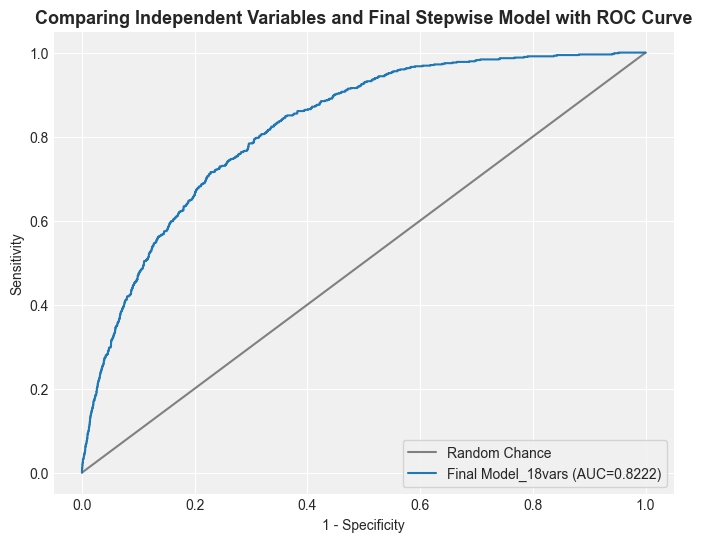

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


def plot_multiple_roc(models, model_names, test_df, target_col="is_fraud"):
    """
    models: list of fitted statsmodels.Logit models
    model_names: list of strings
    test_df: test dataframe
    """
    plt.figure(figsize=(8, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['axes.facecolor'] = '#f0f0f0'

    # 隨機機率線
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-', label='Random Chance')

    auc_values = {}

    for model, name in zip(models, model_names):
        # 取出模型變數
        vars_used = model.params.index.drop("const")
        X_test = sm.add_constant(test_df[vars_used])

        # 計算預測機率
        y_true = test_df[target_col]
        y_score = model.predict(X_test)

        # ROC 曲線
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        auc_values[name] = auc_val

        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.4f})")

    plt.title("Comparing Independent Variables and Final Stepwise Model with ROC Curve", fontsize=13, fontweight='bold')
    plt.xlabel("1 - Specificity")
    plt.ylabel("Sensitivity")
    plt.legend(loc="lower right", frameon=True)
    plt.show()

    # 印出 AUC summary
    #print("AUC values:")
    #for name, val in auc_values.items():
    #    print(f"{name}: {val:.4f}")

# 假設你已經有以下模型：
# model_1 = sm.Logit(y_train, sm.add_constant(X_train[["X13"]])).fit(disp=False)
# model_2 = sm.Logit(y_train, sm.add_constant(X_train[["X17"]])).fit(disp=False)
# final_model = ...

# 範例呼叫
plot_multiple_roc(
    #models=[model_0, model_2, model_3,model_4, final_model],
    models=[final_model],
    model_names=["Final Model"],
    test_df=test_df,
    target_col="is_fraud"
)


# 05_地區分析

驚人發現 "2018-01-01 00:00:00" 到 "2019-10-31 23:59:59"的交易資料中，詐騙高度集中在網路交易、境外交易、ohio州

In [ ]:
df=train_df

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df[df['is_fraud']==0]['zip'], df[df['is_fraud']==0]['al'],
            s=5, alpha=0.4, label='Normal', color='blue')
plt.scatter(df[df['is_fraud']==1]['zip'], df[df['is_fraud']==1]['al'],
            s=10, alpha=0.7, label='Fraud', color='red')
plt.xlabel('zip')
plt.ylabel('al')
plt.title('Geographical Distribution of Fraud vs Normal Transactions')
plt.legend()
plt.show()


In [ ]:
import folium

# 建立地圖中心（以資料平均位置為中心）
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# 加入交易點
for _, row in df.iterrows():
    color = 'red' if row['is_fraud'] == 1 else 'blue'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color=color,
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

m.save('fraud_map.html')


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df["al"]=df['amount']/df["credit_limit"]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# 各類別上色
# 先畫 Fraud
ax.scatter(
           df[df['is_fraud']==1]['zip'],
          
           df[df['is_fraud']==1]['yearly_income'],
           df[df['is_fraud']==1]['al'],
           c='red', label='Fraud', alpha=0.9, s=15)

# 再畫 Normal
ax.scatter(
           df[df['is_fraud']==0]['zip'],
           
           df[df['is_fraud']==0]['yearly_income'],
           df[df['is_fraud']==0]['al'],
           c='blue', label='Normal', alpha=0.01, s=10)


ax.set_xlabel('zip')
ax.set_zlabel('al')
ax.set_ylabel('yearly_income')
ax.set_title('3D Visualization of Fraud by Location and Income')
ax.legend()
plt.show()


In [ ]:
df["al"]=df['amount']/df["credit_limit"]

In [ ]:
df["zip"]==10000

In [ ]:
fraud = df[df["is_fraud"] == 1]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(fraud_all['zip'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of ZIP Codes in fraud_all')
plt.xlabel('ZIP Code')
plt.ylabel('Frequency')
plt.show()
